In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

np.random.seed(1) # for reprodusability of results

In [3]:
%load_ext autoreload
%reload_ext autoreload

In [4]:
df = pd.read_csv('train.csv')

In [5]:
# Helper for manual feature selection
# vars_ = pd.read_csv('vars.csv')
# print(vars_[vars_['type'] == 'ordinal']['name'].tolist())
# print(vars_[vars_['type'] == 'nominal']['name'].tolist())
# print(vars_[vars_['type'] == 'binary']['name'].tolist())
# print(vars_[vars_['type'] == 'continuous']['name'].tolist())
# print(vars_[vars_['type'] == 'discrete']['name'].tolist())
# print(vars_[vars_['type'] == 'date']['name'].tolist())

## Imputing NaN im Numerical Features

In [6]:
#Imputing NA's with 0, as 0 represent No feature
df[['LotFrontage']] = df[['LotFrontage']].fillna(0)
df[['BsmtFullBath']] = df[['BsmtFullBath']].fillna(0)
df[['BsmtHalfBath']] = df[['BsmtHalfBath']].fillna(0)
df[['FullBath']] = df[['FullBath']].fillna(0)
df[['FullBath']] = df[['FullBath']].fillna(0)
df[['GarageCars']] = df[['GarageCars']].fillna(0)

## Imputing NaN - Nominal Features

In [7]:
#Electrical
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(df[['Electrical']])
df[['Electrical']] = pd.DataFrame(imp.transform(df[['Electrical']]), columns = ['Electrical'])

#GarageType (impute + convert to binary)
df[['GarageType']] = df[['GarageType']].fillna('N')
df['Garage'] = (df['GarageType'] != 'N').astype(int)

df[['Functional']] = df[['Functional']].fillna('Typ')

imp.fit(df[['KitchenQual']])
df[['KitchenQual']] = pd.DataFrame(imp.transform(df[['KitchenQual']]), columns = ['KitchenQual'])

## Rearranging Quantitative features

In [8]:
#Total porch area
df['Total.Porch']= df['OpenPorchSF']+ df['EnclosedPorch'] + df['ScreenPorch']

#Total rooms
df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'] - df['BedroomAbvGr']

#Total baths
df['Total.HalfBath'] = df['BsmtFullBath'] + df['FullBath']
df['Total.FullBath'] = df['BsmtHalfBath'] + df['HalfBath']

# Subtracting num of bedrooms from total number of rooms as bedrooms are represented in a separate feature
df['Total.RmsAbvGrd'] = df['TotRmsAbvGrd'] - df['BedroomAbvGr']

## Converting Nominal Features

In [9]:
#Rename one 'MSZoning' value for dummification
df.loc[(df['MSZoning'] == 'C (all)'), 'MSZoning'] = 'C'

#Converting numerical to categorical
df = df.replace({'MSSubClass': {20: 'SC20', 30: 'SC30', 40: 'SC40', 45: 'SC45', 50: 'SC50', 60: 'SC60', 70: 'SC70', 
                                75: 'SC75', 80: 'SC80', 85: 'SC85', 90: 'SC90', 120: 'SC120', 150: 'SC150', 160: 'SC160',
                                180: 'SC180', 190: 'SC190'} })

## Converting Features to Binary

In [10]:
#convert CentralAir to boolean
df['CentralAir'] = (df['CentralAir'] != 'N').astype(int)

#convert Fireplaces to boolean
df.loc[(df['Fireplaces'] > 0), 'Fireplaces'] = 1

# Create a binary feature 'Basement' that indicates if the home has a basement
df['Basement'] = [1 if row > 0 else 0 for row in df['TotalBsmtSF']]

# Pool Area
df['PoolArea'] = [1 if row > 0 else 0 for row in df['PoolArea']]

# YearRemodAdd
# if the year listed in both columns is the same, there has not been a renovation
# Turn into binary variable "Reno"
Year_temp = df.YearRemodAdd - df.YearBuilt
df['Reno'] = [0 if x == 0 else 1 for x in Year_temp]

# Conditions 1 + 2
# Only "Positive Feature" really seems to matter here -> binarize
PosFeat1 = [1 if 'Pos' in x else 0 for x in df['Condition1']]
PosFeat1 = pd.Series(PosFeat1)
PosFeat2 = [1 if 'Pos' in x else 0 for x in df['Condition2']]
PosFeat2 = pd.Series(PosFeat2)
temp = pd.DataFrame()
temp['PosFeat1'] = PosFeat1
temp['PosFeat2'] = PosFeat2
temp['PosFeat'] = temp.PosFeat1 + temp.PosFeat2
# binarize and put into df
df['PosFeat'] = [1 if x > 0 else 0 for x in temp['PosFeat']]
# Just in Case:
# Also binarize "Norm" col
# if Cond1 = norm, so does Cond2, so we only need to look @ one col
df['Norm'] = [1 if 'Norm' in x else 0 for x in df['Condition1']]

df['TwoFloors'] = [1 if "2" in x else 0 for x in df['HouseStyle']]

df['OneFamHome'] = [1 if row == "1Fam" else 0 for row in df['BldgType']]
df['WoodDeck'] = [1 if row > 0 else 0 for row in df['WoodDeckSF']]
df['Porch'] = [1 if row > 0 else 0 for row in df['Total.Porch']]

## Converting Ordinal Features

In [11]:
quality_scale = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

df = df.replace({'HeatingQC': quality_scale,
                 'KitchenQual': quality_scale,
                 'PavedDrive': {'N': 0, 'Y': 2, 'P': 1},
                 'Functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 
                                'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
})

df['LotFrontage'] = [3 if x > 100 else 2 if x > 60 else 1 if x > 0 else 0 for x in df['LotFrontage']]
df['LotArea'] = [2 if x > 12000 else 1 if x > 7000 else 0 for x in df['LotArea']]

## Converting Date Features

In [12]:
# df['YearBuilt'] = pd.DatetimeIndex(df['YearBuilt']).date
# df['YrSold'] = pd.DatetimeIndex(df['YrSold']).date

## Selected Features

In [13]:
ordinal_features = ['PavedDrive', 'Functional', 'OverallQual', 'KitchenQual', 'LotFrontage','HeatingQC', 'LotArea']
nominal_features = ['MSSubClass', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
                    'Neighborhood', 'Electrical', 'SaleCondition', 'MSZoning']
binary_features = ['CentralAir', 'Basement', 'Fireplaces', 'Garage', 'Reno', 'OneFamHome', 
                   'PosFeat', 'Norm', 'TwoFloors', 'PoolArea', 'WoodDeck', 'Porch']
contin_features = ['GrLivArea', 'SalePrice']
discrete_features = ['Total.HalfBath', 'Total.FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars']
date_features = ['YearBuilt', 'YrSold']

## Checking Selected Variables (if in df and data types)

In [14]:
combined_list = ordinal_features+nominal_features+binary_features+contin_features+discrete_features+date_features
print('Number of selected features: ', len(combined_list))
for i in sorted(combined_list):
    print(i, type(df[i][0]))

Number of selected features:  37
Basement <class 'numpy.int64'>
BedroomAbvGr <class 'numpy.int64'>
CentralAir <class 'numpy.int32'>
Electrical <class 'str'>
Fireplaces <class 'numpy.int64'>
Functional <class 'numpy.int64'>
Garage <class 'numpy.int32'>
GarageCars <class 'numpy.int64'>
GrLivArea <class 'numpy.int64'>
HeatingQC <class 'numpy.int64'>
KitchenQual <class 'numpy.int64'>
LandContour <class 'str'>
LandSlope <class 'str'>
LotArea <class 'numpy.int64'>
LotConfig <class 'str'>
LotFrontage <class 'numpy.int64'>
MSSubClass <class 'str'>
MSZoning <class 'str'>
Neighborhood <class 'str'>
Norm <class 'numpy.int64'>
OneFamHome <class 'numpy.int64'>
OverallQual <class 'numpy.int64'>
PavedDrive <class 'numpy.int64'>
PoolArea <class 'numpy.int64'>
Porch <class 'numpy.int64'>
PosFeat <class 'numpy.int64'>
Reno <class 'numpy.int64'>
SaleCondition <class 'str'>
SalePrice <class 'numpy.int64'>
TotRmsAbvGrd <class 'numpy.int64'>
Total.FullBath <class 'numpy.int64'>
Total.HalfBath <class 'numpy.

## Checking for Missingness in Selected Variables

In [15]:
for i in combined_list:
    print(i, df[i].isna().sum())

PavedDrive 0
Functional 0
OverallQual 0
KitchenQual 0
LotFrontage 0
HeatingQC 0
LotArea 0
MSSubClass 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Electrical 0
SaleCondition 0
MSZoning 0
CentralAir 0
Basement 0
Fireplaces 0
Garage 0
Reno 0
OneFamHome 0
PosFeat 0
Norm 0
TwoFloors 0
PoolArea 0
WoodDeck 0
Porch 0
GrLivArea 0
SalePrice 0
Total.HalfBath 0
Total.FullBath 0
BedroomAbvGr 0
TotRmsAbvGrd 0
GarageCars 0
YearBuilt 0
YrSold 0


## Checking Correlation

In [16]:
import matplotlib.pyplot as plt

corr = df[combined_list].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,PavedDrive,Functional,OverallQual,KitchenQual,LotFrontage,HeatingQC,LotArea,CentralAir,Basement,Fireplaces,Garage,Reno,OneFamHome,PosFeat,Norm,TwoFloors,PoolArea,WoodDeck,Porch,GrLivArea,SalePrice,Total.HalfBath,Total.FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageCars,YearBuilt,YrSold
PavedDrive,1.000000,0.084285,0.229393,0.213023,0.075827,0.157502,0.070422,0.337516,0.137638,0.154082,0.327581,-0.215170,0.009230,0.040516,0.109280,-0.003734,0.020111,0.125783,-0.020800,0.080195,0.231357,0.179088,0.115811,-0.032227,0.016593,0.284598,0.427561,0.006556
Functional,0.084285,1.000000,0.145436,0.107003,0.019020,0.058352,-0.012575,0.091402,0.079304,0.007870,0.063584,-0.104535,-0.005462,0.003218,-0.028782,0.036173,0.016453,0.060794,0.040218,-0.068202,0.107619,0.026341,0.051389,-0.033789,-0.037999,0.086819,0.148792,-0.029805
OverallQual,0.229393,0.145436,1.000000,0.673331,0.201492,0.457083,0.212566,0.272038,0.210177,0.438143,0.261968,-0.080468,0.035872,0.069424,0.099223,0.283999,0.073907,0.274294,0.343575,0.593007,0.790982,0.493116,0.230918,0.101676,0.497400,0.600671,0.572323,-0.027347
KitchenQual,0.213023,0.107003,0.673331,1.000000,0.149248,0.504228,0.171335,0.257830,0.124338,0.291603,0.213937,-0.012616,0.032850,0.042705,0.124077,0.167593,0.066028,0.273506,0.295456,0.420563,0.659600,0.441739,0.150996,-0.018012,0.391552,0.509810,0.530165,0.002047
LotFrontage,0.075827,0.019020,0.201492,0.149248,1.000000,0.121196,0.195454,0.045094,0.019010,0.027104,0.032413,-0.034224,0.154008,-0.053990,0.003111,0.019195,0.061510,0.012690,0.065960,0.181235,0.230982,0.119537,0.002940,0.136969,0.161960,0.180549,0.136900,-0.012449
HeatingQC,0.157502,0.058352,0.457083,0.504228,0.121196,1.000000,0.057379,0.306294,0.128914,0.169052,0.127154,0.014207,0.053658,-0.041995,0.091466,0.134382,-0.041521,0.200841,0.267562,0.254644,0.427649,0.310337,0.087204,-0.026869,0.235723,0.325347,0.448855,-0.009649
LotArea,0.070422,-0.012575,0.212566,0.171335,0.195454,0.057379,1.000000,0.124039,0.006742,0.273637,0.159996,-0.039906,0.406148,0.087953,-0.045701,0.038232,0.074697,0.123028,0.076922,0.393977,0.411714,0.242266,0.119674,0.289486,0.301305,0.305779,0.124224,-0.021652
CentralAir,0.337516,0.091402,0.272038,0.257830,0.045094,0.306294,0.124039,1.000000,0.204832,0.200814,0.251471,-0.176320,0.085294,-0.003606,0.064502,-0.010784,0.018311,0.163894,0.033825,0.093666,0.251328,0.163512,0.139590,0.007872,0.040380,0.233726,0.381831,-0.009420
Basement,0.137638,0.079304,0.210177,0.124338,0.019010,0.128914,0.006742,0.204832,1.000000,0.091777,0.094187,0.031747,0.116622,0.022548,0.037157,0.072621,0.011192,0.102197,0.142015,0.069417,0.152829,0.081262,0.128228,0.005655,0.014534,0.078075,0.078510,-0.028943
Fireplaces,0.154082,0.007870,0.438143,0.291603,0.027104,0.169052,0.273637,0.200814,0.091777,1.000000,0.202086,0.035521,0.124285,0.112363,0.005903,0.151115,0.065705,0.206934,0.205328,0.445299,0.471908,0.274431,0.217703,0.105721,0.366450,0.349501,0.221006,-0.049736


## Preparing data for the model
### Dummify:
nominal_features

### Normalize:
contin_features

### Keep as is
discrete_features,
date_features,
ordinal_features,
binary_features

### Log Transform GrLivArea, SalePrice

In [18]:
df['GrLivArea'] = df['GrLivArea'].apply(lambda x: np.log(x))
df['SalePrice'] = df['SalePrice'].apply(lambda x: np.log(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6B712AE80>,
      dtype=object)

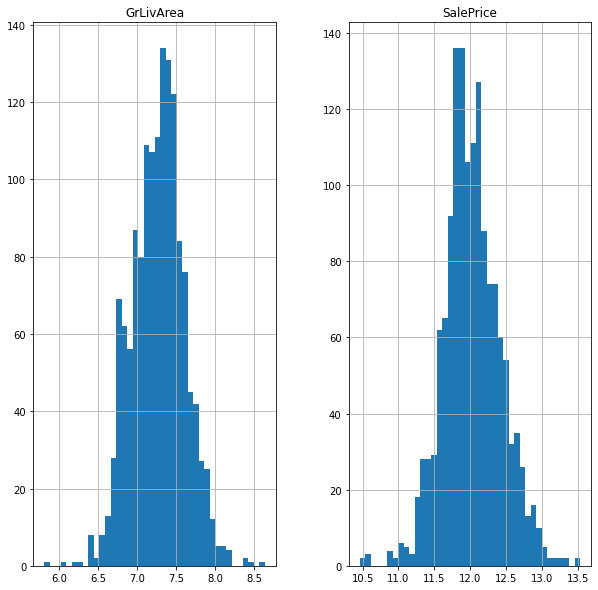

In [19]:
df[['GrLivArea', 'SalePrice']].hist(bins = 40, figsize = (10, 10))
# contin_features

In [20]:
nominal_dummies = df[nominal_features]
nominal_dummies = pd.get_dummies(nominal_dummies, drop_first=True)

In [21]:
# ordinal_features = ['PavedDrive', 'Functional', 'OverallQual', 'KitchenQual', 'LotFrontage','HeatingQC', 'LotArea']
# nominal_features = ['MSSubClass', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
#                     'Neighborhood', 'Electrical', 'SaleCondition', 'MSZoning']
# binary_features = ['CentralAir', 'Basement', 'Fireplaces', 'Garage', 'Reno', 'OneFamHome', 
#                    'PosFeat', 'Norm', 'TwoFloors', 'PoolArea', 'WoodDeck', 'Porch']
# contin_features = ['GrLivArea', 'SalePrice']
# discrete_features = ['Total.HalfBath', 'Total.FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars']
# date_features = ['YearBuilt', 'YrSold']

In [22]:
selection = ordinal_features+binary_features+contin_features+discrete_features+date_features
final_train = df[selection]

# Final data

In [23]:
final_train = pd.concat([final_train, nominal_dummies], axis = 1)
final_train

,PavedDrive,Functional,OverallQual,KitchenQual,LotFrontage,HeatingQC,LotArea,CentralAir,Basement,Fireplaces,...,Electrical_SBrkr,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,2,8,7,4,2,5,1,1,1,0,...,1,0,0,0,1,0,0,0,1,0
1,2,8,6,3,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
2,2,8,7,4,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
3,2,8,7,4,1,4,1,1,1,1,...,1,0,0,0,0,0,0,0,1,0
4,2,8,8,4,2,5,2,1,1,1,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,8,6,3,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
1456,2,7,6,3,2,3,2,1,1,1,...,1,0,0,0,1,0,0,0,1,0
1457,2,8,7,4,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
1458,2,8,5,4,2,4,1,1,1,0,...,0,0,0,0,1,0,0,0,1,0


In [24]:
from pipeline import data_transform

In [25]:
#transforming final test dataset
final_test = data_transform('test.csv')

In [26]:
final_train = final_train.drop(['SalePrice'], axis = 1)

In [27]:
#after dummification the train and test datasets have different columns
#matching columns if train and test sets
missing_in_train = []
missing_in_test = []
for i, j in zip(final_test.columns, final_train.columns):
    if i not in final_train.columns:
        missing_in_train.append(i)
        print(i, ' is missing in final_train')
    if j not in final_test.columns:
        missing_in_test.append(j)
        print(j, ' is missing in final_test')

MSSubClass_SC150  is missing in final_train
Utilities_NoSeWa  is missing in final_test
Electrical_Mix  is missing in final_test


In [28]:
print(missing_in_train)
print(missing_in_test)
print(final_train.shape)
print(final_test.shape)

['MSSubClass_SC150']
['Utilities_NoSeWa', 'Electrical_Mix']
(1460, 88)
(1459, 87)


In [29]:
'''
after you are done dummifying, you can get rid of the columns 
that exists in your test set but doesnt exist in your train set 
and then create new columns in your test set where the column exist in the train but not in test'''

'\nafter you are done dummifying, you can get rid of the columns \nthat exists in your test set but doesnt exist in your train set \nand then create new columns in your test set where the column exist in the train but not in test'

In [30]:
for i in missing_in_train:    
    print(f'dropping {i} in final_test')
    final_test = final_test.drop([i], axis=1)

dropping MSSubClass_SC150 in final_test


In [31]:
for j in missing_in_test:
    print(f'adding {j} to final_test')
    final_test[j] = np.nan
    
final_test[missing_in_test] = final_test[missing_in_test].fillna(0)

adding Utilities_NoSeWa to final_test
adding Electrical_Mix to final_test


In [32]:
#Final check before fitting
print(final_train.shape)
print(final_test.shape)

(1460, 88)
(1459, 88)


## Train-test Split & Area standardizing

In [64]:
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(final_train, y, test_size = 0.3, random_state = 0)
print("X_train : ", X_train.shape)
print("X_test : ", X_test.shape)
print("y_train : ", y_train.shape)
print("y_test : ", y_test.shape)

X_train :  (1022, 88)
X_test :  (438, 88)
y_train :  (1022,)
y_test :  (438,)


In [65]:
stSc = StandardScaler()

## Trying scaling all features including dummies vs scaling numerical only
All features scaled test score = 0.88, only numerical test score = 0.81 (But RMSE look weird)

In [66]:
X_train['GrLivArea'] = stSc.fit_transform(X_train[['GrLivArea']])
X_test['GrLivArea'] = stSc.fit_transform(X_test[['GrLivArea']])

<ipython-input-66-2dfbb5b0ae7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['GrLivArea'] = stSc.fit_transform(X_train[['GrLivArea']])
<ipython-input-66-2dfbb5b0ae7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['GrLivArea'] = stSc.fit_transform(X_test[['GrLivArea']])


## Modeling

### Multiple Linear Regression

In [50]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

In [51]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [67]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [68]:
print("RMSE on Training set :", rmse_cv_train(ols).mean())
print("RMSE on Test set :", rmse_cv_test(ols).mean())

RMSE on Training set : 0.13407693339475557
RMSE on Test set : 0.15184571846112616


In [69]:
ols.score(X_test, y_test)

0.879448339313745

# Trying to select the most significant features

In [70]:
import statsmodels.api as sm 
X_add_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     111.3
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:12:38   Log-Likelihood:                 729.32
No. Observations:                1022   AIC:                            -1281.
Df Residuals:                     933   BIC:                            -841.9
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.54

In [ ]:
significant_features = ans.pvalues[ans.pvalues < 0.05].index.tolist()
try:
    significant_features.remove('const')
except: pass

In [ ]:
significant_features

## Try Linear regression again with selected features

In [ ]:
X_train = X_train[significant_features]

In [ ]:
ols1 = LinearRegression()
ols1.fit(X_train, y_train)

In [ ]:
ols1.score(X_test[significant_features], y_test)

#### The model performs worse than with non-redused set of predictors. Why?

In [ ]:
print("RMSE on Training set :", rmse_cv_train(ols1).mean())
print("RMSE on Test set :", rmse_cv_test(ols1).mean())

## RidgeCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_train, y, test_size = 0.3, random_state = 0)

alphas = np.linspace(0.001, 10, 1000)
ridge = RidgeCV(alphas = alphas)
ridge.fit(X_train, y_train)

alpha = ridge.alpha_
print("Best alpha :", alpha)

In [ ]:
print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

#### Ridge with alpha= 1.463 performed slightly worse than with non-redused set of predictors.

In [ ]:
ridge.score(X_test, y_test)

In [ ]:
multipliers = np.linspace(0.4, 1.4, 100)
alphas = multipliers*alpha

In [ ]:
ridge = RidgeCV(alphas)
ridge.fit(X_train, y_train)

alpha = ridge.alpha_
print("Best alpha :", alpha)

In [ ]:
print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

In [ ]:
ridge.score(X_test, y_test)

# Exporting Predictions

In [ ]:
Id_test = pd.read_csv('test.csv')['Id']
predicted_price = pd.Series(np.exp(ols.predict(final_test)))

In [ ]:
Id_test = pd.read_csv('final_test.csv')['Id']

predicted_price = pd.Series(np.exp(ols.predict(final_test)))

submission = pd.DataFrame({'Id': Id_test, 'SalePrice': predicted_price})

submission.to_csv('submission.csv', index=False)

In [ ]:
submission.to_csv('submission.csv', index=False)